Retrieves images from "raw_imgs" folder and stores them in "full_imgs". Retrieves spreadsheet listing VOIs and stores them in text file.

TODO: function to read existing vois, drop one class, then load the class back in. Requires that drm.load_imgs write to a DataFrame rather than an array

In [1]:
import cnn_builder as cbuild
import cnn_methods as cfunc
import config
import csv
import dr_methods as drm
import helper_fxns as hf
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyelastix
import time
import transforms as tr
import voi_methods as vm
%matplotlib inline

Using TensorFlow backend.


In [44]:
importlib.reload(cbuild)
importlib.reload(cfunc)
importlib.reload(config)
importlib.reload(hf)
importlib.reload(tr)
importlib.reload(vm)
importlib.reload(drm)
C = config.Config()

# Reload images and VOIs

In [ ]:
drm.load_vois_all(C)

In [47]:
for cls in C.classes_to_include:
    if not os.path.exists(C.full_img_dir + "\\" + cls):
        os.makedirs(C.full_img_dir + "\\" + cls)
    if not os.path.exists(C.orig_dir + cls):
        os.makedirs(C.orig_dir + cls)
    if not os.path.exists(C.aug_dir + cls):
        os.makedirs(C.aug_dir + cls)
    if not os.path.exists(C.crops_dir + cls):
        os.makedirs(C.crops_dir + cls)

In [71]:
#dims_df = pd.DataFrame(columns = ["AccNum", "x", "y", "z"])
dims_df = pd.read_csv(C.dims_df_path)
voi_df_art = pd.DataFrame(columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls",
                                     "flipz", "real_dx", "real_dy", "real_dz", "id", "lesion_num"])
voi_df_ven = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2"]) #voi_df_ven only contains entries where manually specified
voi_df_eq = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2"]) #voi_df_ven only contains entries where manually specified
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]

In [4]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]
dims_df = pd.read_csv(C.dims_df_path)
intensity_df = pd.read_csv(C.int_df_path)
#intensity_df = drm.get_intensities(C, cls="hcc", acc_num='E106046622')

In [26]:
intensity_df = drm.get_intensities(C, cls="hemangioma", acc_num='13138944')

In [101]:
patient_info_df = pd.DataFrame(columns = ["MRN", "Sex", "AccNum", "AgeAtImaging", "cls"])
for i in [C.sheetnames.index(x) for x in ['Cholangio']]:
    #drm.check_folders(img_dirs[i], xls_name, sheetnames[i], C)
    #dims_df = drm.load_imgs(img_dirs[i], cls_names[i], xls_name, sheetnames[i], dims_df, C)
    #voi_dfs = drm.load_vois_batch(cls_names[i], xls_name, sheetnames[i], voi_dfs, dims_df, C)#, acc_nums=['E104764948','E106046622'])
    #intensity_df = drm.get_intensities(C, cls=cls_names[i], acc_num='E106046622')
    patient_info_df = drm.load_patient_info("Z:\\"+C.img_dirs[i], C.cls_names[i], C.sheetnames[i], patient_info_df, C,
                                           acc_nums=['11534565','E102310482'])
patient_info_df.to_csv('Z:\\patient_info_missing.csv', index=False)


Loading DCMs of type Cholangio
Overall time: 1.1657507419586182


In [345]:
voi_df_art, voi_df_ven, voi_df_eq = voi_dfs
voi_df_art.to_csv(C.art_voi_path, index=False)
voi_df_ven.to_csv(C.ven_voi_path, index=False)
voi_df_eq.to_csv(C.eq_voi_path, index=False)

In [346]:
dims_df.to_csv(C.dims_df_path, index=False)

In [ ]:
#drm.delete_imgs(['12916368', 'E102556695'], 'hcc', C)
#drm.delete_imgs(0, cls, C, xls_name, sheetname)
drm.reload_img("E102310482", "cholangio", C)


Loading DCM for ['E102310482']


# Generate cropped imgs

In [ ]:
for acc_num in ['E102310482']:
    vm.reload_accnum(acc_num, "cholangio", C, augment=True, overwrite=True)

In [45]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)
intensity_df = pd.read_csv(C.int_df_path)

#C.classes_to_include = ['hcc', 'cholangio', 'colorectal', 'cyst', 'hemangioma', 'fnh']

with open(C.small_voi_path, 'r') as csv_file:
    reader = csv.reader(csv_file)
    small_vois = dict(reader)
for key in small_vois:
    small_vois[key] = [int(x) for x in small_vois[key][1:-1].split(', ')]

In [48]:
small_vois = {}
small_vois = vm.extract_vois(small_vois, C, voi_df_art, voi_df_ven, voi_df_eq, intensity_df)

with open(C.small_voi_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in small_vois.items():
        writer.writerow([key, value])

.....................
710.1280641555786


In [49]:
# scaled imgs
t = time.time()
for cls in C.classes_to_include:
    for fn in os.listdir(C.crops_dir + cls):
        img = np.load(C.crops_dir + cls + "\\" + fn)
        try:
            unaug_img = vm.resize_img(img, C, small_vois[fn[:-4]])
        except Exception as e:
            print(cls, e)
            continue
        np.save(C.orig_dir + cls + "\\" + fn, unaug_img)
print(time.time()-t)

for cls in C.classes_to_include:
    vm.save_vois_as_imgs(cls, C)

47.16417598724365


In [70]:
# augmented imgs
t = time.time()
for cls in C.classes_to_include:
    vm.parallel_augment(cls, small_vois, C, num_cores=3, overwrite=50)
    print(cls, time.time()-t)

hcc 158.17009925842285
cholangio 235.76278376579285
colorectal 354.5679666996002
cyst 634.770115852356
hemangioma 793.7477686405182
fnh 1024.9949328899384


# Plotting

In [113]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_art[voi_df_art["Filename"] == "E104949189.npy"]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,real_dx,real_dy,real_dz,id,lesion_num
472,E104949189.npy,74,87,61,73,42,52,fnh,False,17.152199,15.832799,30.0,E104949189_0,0


-0.00952623 255.0 8.38156


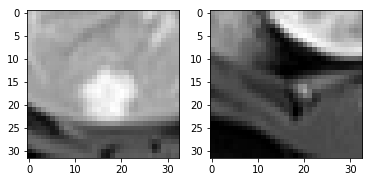

In [114]:
# can be used to determine if an image is flipped
cls = "fnh"
acc_num = 'E104949189'#acc_nums[0]
img_fn = acc_num + ".npy"
img = np.load(C.full_img_dir+"\\"+cls + "\\"+img_fn)
hf.plot_slice_flips(img, voi_df_art[(voi_df_art["Filename"] == img_fn) & (voi_df_art["cls"] == cls)].iloc[0], flipz="both", pad=10)
print(np.amin(img), np.amax(img), np.mean(img))
#hf.plot_section_auto(img)

In [ ]:
# Cropped, rescaled or augmented imgs
img = drm.plot_check("cholangio", 2, C, "E102310482"+"_0")
print(np.amin(img), np.amax(img), np.mean(img))

# Run CNN

In [ ]:
cbuild.overnight_run(C)

# Situational

for img_fn in os.listdir(C.full_img_dir):
    try:
        cls = voi_df_art[voi_df_art["Filename"] == img_fn]["cls"].values[0]
        os.rename(C.full_img_dir + "\\" + img_fn, C.full_img_dir + "\\" + cls + "\\" + img_fn)
    except:
        continue

In [76]:
df = pd.read_excel(xls_name, sheetname)
df = drm.preprocess_df(df, C)
acc_nums = list(set(df['Patient E Number'].dropna().astype(str).tolist()))

In [ ]:
xls_name = 'Z:\\Prototype1d.xlsx'
img_dir = "Z:\\cholangio"
cls = 'cholangio'
sheetname="Cholangio"
df = pd.read_excel(xls_name, sheetname)
accnums = df[df['Run'] > C.run_num]['Patient E Number'].values

In [ ]:
for img_fn in sorted(set(voi_df[voi_df["cls"] == "cyst"]['Filename'])):
    img = np.load("full_imgs\\"+img_fn)
    if np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,:img.shape[2]//3]) > \
            np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,(img.shape[2]+1)*2//3:]):
        print(img_fn)

for cls in os.listdir(C.aug_dir):#classes_to_include:
    for img_fn in os.listdir(C.aug_dir + cls):
        if "refl" in img_fn:
            os.remove(C.aug_dir + cls + "\\" + img_fn)

img = img * 2 - 1

for cls in C.classes_to_include:
    fns = os.listdir(C.crops_dir + cls)
    for fn in fns:
        img = np.load(C.crops_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.crops_dir + cls + "\\" + fn, img)

for cls in C.classes_to_include:
    fns = os.listdir(C.orig_dir + cls)
    for fn in fns:
        img = np.load(C.orig_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.orig_dir + cls + "\\" + fn, img)

for cls in C.classes_to_include:
    fns = os.listdir(C.aug_dir + cls)
    for fn in fns:
        img = np.load(C.aug_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.aug_dir + cls + "\\" + fn, img)

for cls in os.listdir(C.aug_dir):#classes_to_include:
    for img_fn in os.listdir(C.aug_dir + cls):
        if "refl" not in img_fn:
            img = np.load(C.aug_dir + cls + "\\" + img_fn)
            aug_img = tr.generate_reflected_img(img)
            np.save(C.aug_dir + cls + "\\" + img_fn[:-4] + "-refl", aug_img)